## 包的导入
需要注意的是将tqdm 改为tqdm.notebook，从而在notebook环境下获得更好的体验。因为导入tqdm的话，会发生进度条打印多次的情况，体验很不好

In [1]:
import os 
import pandas as pd 
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms,models,utils
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook as tqdm
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter 
# from torchvision import datasets, transforms,utils

相关文件路径配置，在pycharm项目中将相关路径的配置都统一放在config.py中来管理

In [2]:
train_path = 'D:/AIdata/dog vs cat/train'
test_path = 'D:/AIdata/dog vs cat/test1'
data_root = 'D:/AIdata/dog vs cat/'
csv_path = './submission_valnet.csv'
tensorboard_path='C:/Users/BraveY/Documents/BraveY/AI-with-code/dog-vs-cat/tensorboard'
model_save_path = 'C:/Users/BraveY/Documents/BraveY/AI-with-code/dog-vs-cat/modelDict/dogs-vs-cats-notebook.pth'

## 数据集的创建
因为Kaggle官方提供的是[原始数据](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)，不像之前的手写数字数据集可以从pytorch中直接下载已经处理过的数据集，可以直接将数据放入模型进行训练。因此需要我们自己实现数据集的生成。

数据集生成的总体思路是继承torch.utils.data.Dataset这个类，自己实现__getitem__和__len__这两个私有方法来完成对我们自己数据的读取操作。其中__getitem__这个函数的主要功能是根据样本的索引，返回索引对应的一张图片的图像数据X与对应的标签Y，也就是返回一个对应的训练样本。__len__这个函数的功能比较简单直接返回数据集中样本的个数即可。

具体而言，__getitem__的实现思路比较简单，将索引idx转换为图片的路径，然后用PIL的Image包来读取图片数据，然后将数据用torchvision的transforms转换成tensor并且进行Resize来统一大小（给出的图片尺寸不一致）与归一化，这样一来就可以得到图像数据了。因为训练集中图片的文件名上面带有猫狗的标签，所以标签可以通过对图片文件名split后得到然后转成0,1编码。

在获取标签的时候，因为官方提供的测试数据集中并没有猫狗的标签，所以测试集的标签逻辑稍有不同。我的做法是使用一个train标志来进行区分，对于测试的数据，直接将测试样本的标签变成图片自带的id，这样方便后面输出提交的csv文件。因为测试样本不用计算loss，所以将标签置为id是没问题的。

为了实现将idx索引转换成图片路径，需要在__init__()函数中将所有的图片路径放在一个list中，这可以用os.listdir()来实现，然后就可以根据索引去获得路径了。

需要注意的是，之所以__getitem__()需要根据索引来返回样本，是因为训练数据并不是一次性将所有样本数据加载到内存中，这样太耗内存。而是只用加载对应batch中的一部分数据，所以通过索引来加载送入模型中的一批数据。

In [3]:
class MyDataset(Dataset):
    def __init__(self, data_path:str, train=True, transform=None):
        self.data_path = data_path
        self.train_flag = train
        if transform is None:
            self.transform = transforms.Compose(
            [
                transforms.Resize(size = (224,224)),#尺寸规范
                transforms.ToTensor(),   #转化为tensor
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            self.transform = transform
        self.path_list = os.listdir(data_path)
    def __getitem__(self, idx: int):
        # img to tensor and label to tensor
        img_path = self.path_list[idx]
        if self.train_flag is True:
            if img_path.split('.')[0] == 'dog' : 
                label = 1
            else:
                label = 0
        else:
            label = int(img_path.split('.')[0]) # split 的是str类型要转换为int
        label = torch.as_tensor(label, dtype=torch.int64) # 必须使用long 类型数据，否则后面训练会报错 expect long
        img_path = os.path.join(self.data_path, img_path)
        img = Image.open(img_path)
        img = self.transform(img)
        return img, label
    def __len__(self) -> int:
        return len(self.path_list)

测试一下，确保Dataset可以正常迭代

In [4]:
train_ds = MyDataset(train_path)
test_ds = MyDataset(test_path,train=False)
for i, item in enumerate(tqdm(train_ds)):
#     pass
    print(item)
    break


(tensor([[[ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8902,  0.8745],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8980,  0.8824],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.9059,  0.8902],
         ...,
         [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
         [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
         [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

        [[ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5843,  0.5686],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5922,  0.5765],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.6000,  0.5843],
         ...,
         [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
         [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
         [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

        [[-0.3176, -0.3020, -0.2706,  ..., -0.0588, -0.0431, -0.0510],
         [-0.3176, -0.3020, -0.2706,  ..., -

## 数据集划分
如前面所述，因为官方测试集没有标签，而且提交结果上去后只有一个log loos来作为分值，没有准确率的结果。所以为了得到准确率这个指标，需要新建个有标签的验证集来查看准确率。

实现思路是使用torch.utils.data.random_split(),来将官方提供训练数据集划分出一部分的验证集。我的比例是80%的训练集，20%的验证集


In [5]:
full_ds = train_ds
train_size = int(0.8 * len(full_ds))
validate_size = len(full_ds) - train_size
new_train_ds, validate_ds = torch.utils.data.random_split(full_ds,[train_size, validate_size])#数据集划分

## 数据加载
我们制作的数据集并不能直接放入模型进行训练，还需要使用一个数据加载器，来加载数据集。使用torch.utils.data.DataLoader()来划分每个batch用来后面训练的时候向网络提供输入数据

In [6]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
## numworkers设置不为0 会报错 Broken pipe Error 网上说是win10上的pytorch bug

In [7]:
new_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
validate_loader = torch.utils.data.DataLoader(validate_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)

加载过后数据形状从三维变成四维，多的维度是batch_size，这里是32个样本构成一个batch

In [8]:
for i, item in enumerate(train_loader):
#     pass
    print(item[0].shape)
    break

torch.Size([32, 3, 224, 224])


### resize后的图像查看
前面提到过对数据进行了resize和正则化的处理，下面是对处理后的图像的可视化

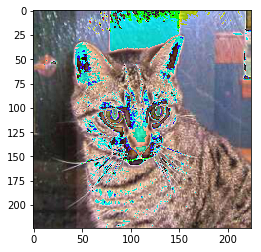

In [9]:
img_PIL_Tensor = train_ds[1][0]
new_img_PIL = transforms.ToPILImage()(img_PIL_Tensor).convert('RGB')
plt.imshow(new_img_PIL)
plt.show()
# print(new_img_PIL.show())

## 网络搭建
网络搭建的框架与之前的[手写数字识别](https://zhuanlan.zhihu.com/p/112829371)的框架一致，两个卷积层后3个全连接层。需要注意的是参数不能套用之前的参数了，因为之前的手写数字的图片很小，而且数据量不大所以尽管参数比较大，也能在我的机子上跑起来(MX150,2GB显存)。猫狗的数据量显然比之前的大，所以需要将参数变小些，才能跑起来。 我实验了下，如果不将网络参数降低的话，只调整batch_size没有用，依然会报显存不足。

In [10]:
import torch.nn.functional as F
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1) # 按照公式计算后经过卷积层不改变尺寸
        self.pool = nn.MaxPool2d(2,2) # 2*2的池化 池化后size 减半
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(16*56*56,256)#两个池化，所以是224/2/2=56
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,2)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
#         print("input:", x)
        x = self.pool(F.relu(self.conv1(x)))
#         print("first conv:", x)
        x = self.pool(F.relu(self.conv2(x)))
#         print("second conv:", x)
             
        x = x.view(-1, 16 * 56* 56)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x
        
   

### 预训练模型
除了自己手动DIY一个网络，也可以使用Pytorch已经提供的一些性能很好的模型比如VGG16，ResNet50等等，然后微调下网络结构，来得到符合自己的任务的网络架构。还可以直接下载这些模型在ImageNet上的预训练参数，然后在自己的数据集上进行训练。

我在这儿选择了ResNet50网络以及预训练好的权重进行了下实验，我在实验室的机器上面用P100跑的，因为自己的笔记本显卡太垃圾了只有2GB显存。

In [11]:
## 直接设置为True的话下载权重太慢了
## 所以手动用浏览器下载好了之后再重新加载
resnet50 = models.resnet50(pretrained=False)  
model_path = 'D:/AIdata/dog vs cat/resnet50-19c8e357.pth'
resnet50.load_state_dict(torch.load(model_path))
resnet50.fc = nn.Linear(2048, 2) #修改最后一层网络将输出调整为两维

## 损失函数和优化函数

In [12]:
net = MyCNN()
# net = resnet50

In [13]:

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()  #二分类交叉熵损失函数
# criterion = nn.BCEWithLogitsLoss() #二分类交叉熵损失函数 带log loss
# criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)   

##  训练日志的打印

在之前的手写数字识别的准确率的计算和画图以日志的打印比较简单，在这更新为topk准确率以及使用tensorboard来画曲线。并且使用tqdm进度条来实时的打印日志。


专门建立一个类来保存和更新准确率的结果，使用类来让代码更加的规范化

In [14]:
class AvgrageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

## 准确率的计算
torch.topk(input, k, dim=None, largest=True, sorted=True, out=None) -> (Tensor, LongTensor) 返回某一维度前k个的索引
input：一个tensor数据
k：指明是得到前k个数据以及其index
dim： 指定在哪个维度上排序， 默认是最后一个维度
largest：如果为True，按照大到小排序； 如果为False，按照小到大排序
sorted：返回的结果按照顺序返回
out：可缺省，不要

In [15]:
## topk的准确率计算
def accuracy(output, label, topk=(1,)):
    maxk = max(topk) 
    batch_size = label.size(0)
    
    # 获取前K的索引
    _, pred = output.topk(maxk, 1, True, True) #使用topk来获得前k个的索引
    pred = pred.t() # 进行转置
    # eq按照对应元素进行比较 view(1,-1) 自动转换到行为1,的形状， expand_as(pred) 扩展到pred的shape
    # expand_as 执行按行复制来扩展，要保证列相等
    correct = pred.eq(label.view(1, -1).expand_as(pred)) # 与正确标签序列形成的矩阵相比，生成True/False矩阵
#     print(correct)

    rtn = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0) # 前k行的数据 然后平整到1维度，来计算true的总个数
        rtn.append(correct_k.mul_(100.0 / batch_size)) # mul_() ternsor 的乘法  正确的数目/总的数目 乘以100 变成百分比
    return rtn

### tensorboard画图
详细的参数讲解参考：https://www.pytorchtutorial.com/pytorch-builtin-tensorboard/ 
在使用pip install安装tensorboard如果速度很慢经常断线的话可以换个国内的源：
`pip config set global.index-url https://mirrors.ustc.edu.cn/pypi/web/simple `

# tesnor 图片

In [16]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter('./tensorboard/')

## 迭代训练

In [17]:
def train( epochs, train_loader, device, model, criterion, optimizer,tensorboard_path):
    model = model.to(device)
    for epoch in range(epochs):
        train_loader = tqdm(train_loader)
        train_loss = 0.0
        model.train()
        top1 = AvgrageMeter()
        train_loader.set_description('[%s%04d/%04d %s%f]' % ('Epoch:', epoch + 1, epochs, 'lr:', 0.001))
        for i, data in enumerate(train_loader, 0):  # 0是下标起始位置默认为0
            inputs, labels = data[0].to(device), data[1].to(device)
            # 初始为0，清除上个batch的梯度信息
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            #topk准确率
            prec1, prec2 = accuracy(outputs, labels, topk=(1, 2))
            n = inputs.size(0)
            top1.update(prec1.item(), n)
            train_loss += loss.item()
            postfix = {'train_loss': '%.6f' % (train_loss / (i + 1)), 'train_acc': '%.6f' % top1.avg}
            train_loader.set_postfix(log=postfix)

            # ternsorboard 曲线绘制
            writer = SummaryWriter(tensorboard_path)
            writer.add_scalar('Train/Loss', loss.item(), epoch)
            writer.add_scalar('Train/Accuracy', top1.avg, epoch)
            writer.flush()

    print('Finished Training')

##  模型评估
准确率验证
在验证集上面的验证，求网络的的准确率指标

In [18]:
def validate(validate_loader, device, model, criterion):
    val_acc = 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():  # 进行评测的时候网络不更新梯度
        val_top1 = AvgrageMeter()
        validate_loader = tqdm(validate_loader)
        validate_loss = 0.0
        for i, data in enumerate(validate_loader, 0):  # 0是下标起始位置默认为0
            inputs, labels = data[0].to(device), data[1].to(device)
            #         inputs,labels = data[0],data[1]
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            prec1, prec2 = accuracy(outputs, labels, topk=(1, 2))
            n = inputs.size(0)
            val_top1.update(prec1.item(), n)
            validate_loss += loss.item()
            postfix = {'validate_loss': '%.6f' % (validate_loss / (i + 1)), 'validate_acc': '%.6f' % val_top1.avg}
            validate_loader.set_postfix(log=postfix)
        val_acc = val_top1.avg
    return val_acc

## 输出测试集的预测结果
将测试集输入进网络，得到测试集的预测结果，并转换成csv文件，用来提交到Kaggle上进行评分。需要注意的是，因为官网要求给的是图片是狗的概率，需要将网络的输出转成概率值。


但实际上测试的时候网络的输出是一正一负的值，不是概率值。这是因为测试的时候没有计算loss ，而softmax这个过程是在计算交叉熵的时候自动计算的，所以在网络架构中最后一层全连接输出后没有softmax计算。因此需要我们手动增加上softmax的过程，这样经过softmax后就可以变成两个概率值了!将图片是狗的概率保存下来，并转成符合官方要求的提交格式。

In [19]:
def submission(csv_path,test_loader, device, model):
    result_list = []
    model = model.to(device)
    test_loader = tqdm(test_loader)
    with torch.no_grad():  # 进行评测的时候网络不更新梯度
        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            softmax_func = nn.Softmax(dim=1)  # dim=1表示行的和为1
            soft_output = softmax_func(outputs)
            predicted = soft_output[:, 1]
            for i in range(len(predicted)):
                result_list.append({
                    "id": labels[i].item(),
                    "label": predicted[i].item()
                })
    # 从list转成 dataframe 然后保存为csv文件
    columns = result_list[0].keys()
    result_dict = {col: [anno[col] for anno in result_list] for col in columns}
    result_df = pd.DataFrame(result_dict)
    result_df = result_df.sort_values("id")
    result_df.to_csv(csv_path, index=None)

## 完整调用流程


 损失函数和优化方法的确定

In [20]:
net = MyCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()  #二分类交叉熵损失函数
# criterion = nn.BCEWithLogitsLoss() #二分类交叉熵损失函数 带log loss
# criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)   

训练过程，需要传入epoch数目，训练数据加载器，设备，网络模型，损失函数，优化方法和tensorboard画图的路径等参数。
注意的是如果使用完整的官方训练数据集来训练网络后，用这个网络去在验证集上面验证是没有意义的，因为验证集的数据是从完整训练数据集上面划分出来，所以相当于在用训练数据验证性能。用划分过后的new_train_loader训练的网络在进行验证才有意义。

In [21]:
# train( 1, train_loader, device,net, criterion, optimizer,tensorboard_path) # 完整的训练数据集
train( 1, new_train_loader, device,net, criterion, optimizer,tensorboard_path) # 划分80%后的训练数据集


Finished Training


在训练的时候会用tensorboard保存每个时刻的训练数据，需要新打开一个命令端口输入：
`tensorboard --logdir=/path_to_log_dir/ --port 6006` 命令，然后通过在浏览器中输入网址http://localhost:6006/ 来查看

模型的保存和加载

In [22]:
torch.save(net.state_dict(), model_save_path)
val_net = MyCNN()
val_net.load_state_dict(torch.load('./dogs-vs-cats_12epoch_valnet.pth'))

<All keys matched successfully>

验证过程，输入的网络是上面训练过的网络，或者从模型权重保存路径加载的模型。输出模型在自己划分的验证集上面的准确率，结果是98.84%

In [23]:
validate(validate_loader,device,val_net,criterion)

98.92

输出测试集预测结果

In [24]:
submission('./test.csv',test_loader, device, val_net)

最后在Kaggle上提交预测结果csv文件，得到打分。 需要先报名参赛这些操作，而且只有Dogs vs. Cats Redux: Kernels Edition这个才能够提交数据，最开始的那个6年前的提交通道已经关闭了。提交可以下载Kaggle的API在命令行提交，也可以直接在[提交链接](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/submit)提交

## 结果
我总共训练了三个网络，其中full_net 使用全部的训练数据，val_net使用划分过的训练数据，RestNet50是预训练的模型，使用完整训练数据训练

## 问题
自己在搭建网络的时候遇到一个问题就是随便设置的一个网络结构的时候，发现交叉熵的loss会一直维持在0.69，不下降。暂时还没有搞懂问题出在哪儿，后面有时间了研究下，

## 参考
https://www.pytorchtutorial.com/pytorch-builtin-tensorboard/ tensorboard画图
https://www.zhihu.com/question/38341743 源的更新
https://www.cnblogs.com/marsggbo/p/10496696.html 数据集的划分
https://github.com/ShunLu91/Single-Path-One-Shot-NAS topk的计算